Full disclaimer,,,
 
I ripped tf outta this MIT lecture [here](https://ocw.mit.edu/courses/15-071-the-analytics-edge-spring-2017/pages/linear-regression/moneyball-the-power-of-sports-analytics/) where they did it in R.  

But I made it cooler and better. 

# ISBE 
* I - Inspect
* S - Select
* B - Build
* E - Evaluate 

In [1]:
# PANDAS IS FOR DATA WRANGLING
import pandas as pd
import numpy as np

# SEABORN IS A PLOTTING LIBRARY
import seaborn as sns

# MATPLOT LIB IS ALSO A PLOTTING LIBRARY
import matplotlib.pyplot as plt

# SKLEARN IS OUR MACHINE LEARNING PACKAGE
from sklearn.linear_model import LinearRegression

# IMPORT OUR RANDOM FOREST REGERSSOR
from sklearn.ensemble import RandomForestRegressor

# METRICS HELP US SCORE OUR MODEL
from sklearn import metrics

# HELP US SPLIT OUR DATA INTO TESTING A TRAINING
from sklearn.model_selection import train_test_split

# Good ol statsmodels
import statsmodels.api as sm

# Specific root mean squared error for stats models
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

In [2]:
# BASEBALL DATA PIPELINE

def load_baseball_data(from_year=2002):
    df = pd.read_csv('data/baseball.csv')

    # Moneyball happened in 2002. 
    # So lets travel back there and remove all data after then. 
    if from_year:
        c1 = df['Year'] < from_year 
        df = df[c1]
        df = df.reset_index(drop=True)

    # calculates the Runs Scored - Runs Allowed as runs_diff
    df['runs_diff'] = df['RS'] - df['RA']
    df['RD'] = df['RS'] - df['RA']
    
    # Return the data.
    return(df)


df = load_baseball_data()
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff,RD
0,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39,-39
1,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141,141
2,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86,86
3,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142,-142
4,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27,27


#### Data Dictionary

| **Column**       | **Description**                                          |
| ---------------- | -------------------------------------------------------- |
| **Team**         | Name of the team                                         |
| **League**       | Name of the league                                       |
| **Year**         | Year of the season                                       |
| **RS**           | Runs scored by the team                                  |
| **RA**           | Runs allowed by the team                                 |
| **W**            | Number of wins                                           |
| **OBP**          | On-Base Percentage                                       |
| **SLG**          | Slugging Percentage                                      |
| **BA**           | Batting Average                                          |
| **Playoffs**     | Whether the team made the playoffs (`1 = Yes`, `0 = No`) |
| **RankSeason**   | Unknown / not specified                                  |
| **RankPlayoffs** | Unknown / not specified                                  |
| **G**            | Number of games played                                   |
| **OOBP**         | Opponent On-Base Percentage                              |
| **OSLG**         | Opponent Slugging Percentage                             |
| **runs_diff**    | Runs scored minus runs allowed (`RS - RA`)               |


In [3]:
print('\n', '#'*79)
###############################################################################
print('CHECKING SHAPE AND SIZE:  df.shape', df.shape)
print('\n', '#'*79)

###############################################################################
print( "CHEKCING NULLS", "print(df.isnull().sum())")
print(df.isnull().sum())
print('\n', '#'*79)

###############################################################################
print("CHECKING DUPES, df.duplicated().sum()")
print(df.duplicated().sum())    



 ###############################################################################
CHECKING SHAPE AND SIZE:  df.shape (902, 17)

 ###############################################################################
CHEKCING NULLS print(df.isnull().sum())
Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      748
RankPlayoffs    748
G                 0
OOBP            812
OSLG            812
runs_diff         0
RD                0
dtype: int64

 ###############################################################################
CHECKING DUPES, df.duplicated().sum()
0


# SCORING RUNS
_Lets build a Linear Regression model to see what is most important to predict how many runs we score from the data we have_

In [4]:
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff,RD
0,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39,-39
1,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141,141
2,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86,86
3,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142,-142
4,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27,27


In [5]:
dependent_variable = 'RS'
independent_variables = ['Year', 'OBP', 'SLG', 'BA', 'RA', 'W', 'Playoffs', 'G', 'RD']

X = df[independent_variables]
y = df[dependent_variable]

X.head()

,Year,OBP,SLG,BA,RA,W,Playoffs,G,RD
0,2001,0.327,0.405,0.261,730,75,0,162,-39
1,2001,0.341,0.442,0.267,677,92,1,162,141
2,2001,0.324,0.412,0.260,643,88,1,162,86
3,2001,0.319,0.380,0.248,829,63,0,162,-142
4,2001,0.334,0.439,0.266,745,82,0,161,27


In [ ]:
import statsmodels.api as sm

## we have to add a constant to our X data (a column of just all 1's)
X = sm.add_constant(X)

# build our model
model_wins = sm.OLS(y, X).fit()

# make new predictions
y_pred = model_wins.predict(X) 

TypeError: object of type 'int' has no len()

In [ ]:
# get the summary report
results = model_wins.summary2()
print(results)


# get root mean squared error
model_wins_root_mean_squared_error = rmse(y, y_pred)
print('#'*79)
print( 'Dependent Variable %s average: ' % dependent_variable, y.mean())
print( 'RMSE:', model_wins_root_mean_squared_error)


# What is wonky about the Regression Summary above....?
0. What are we trying to predict...?
0. What are we using to predict that? 
0. What are the assumptions of Linear Regression. 

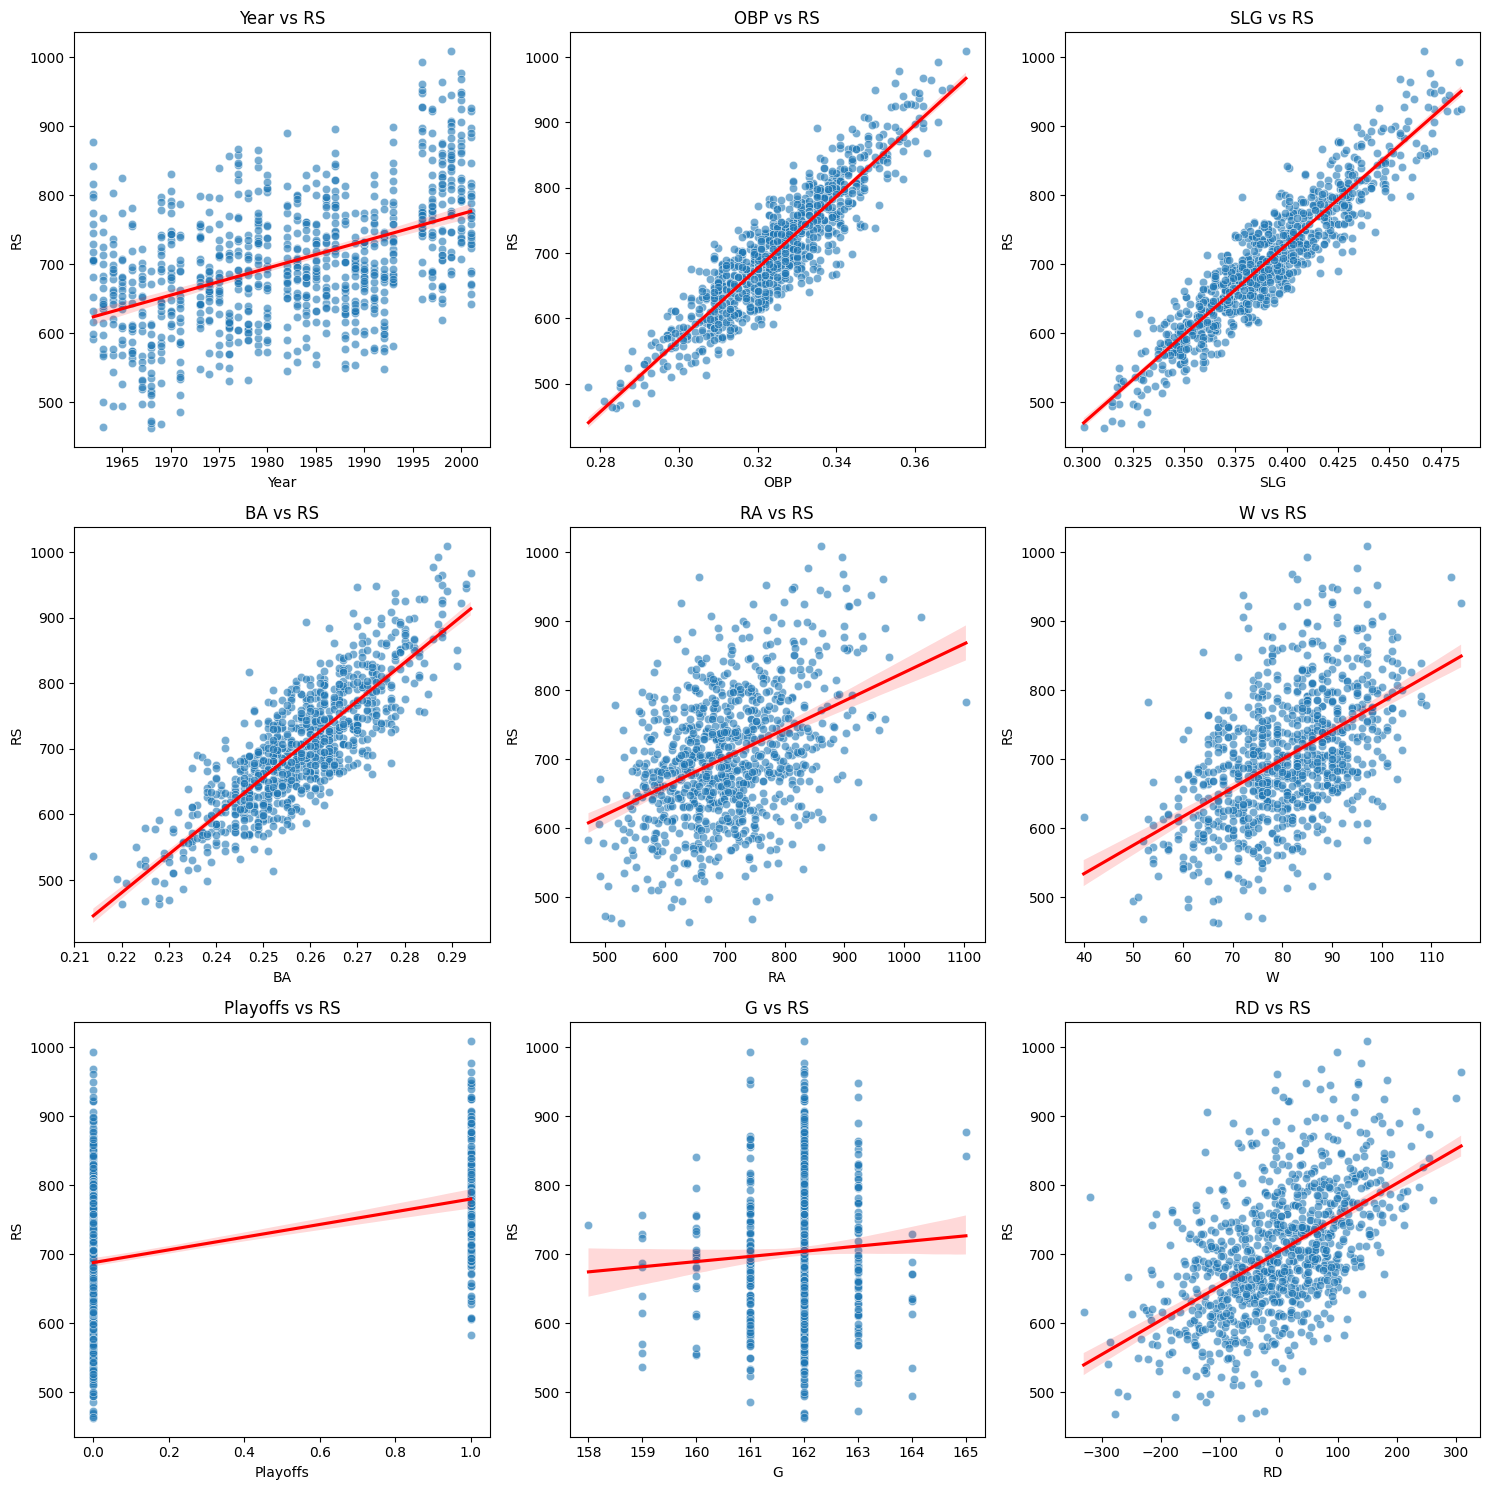

In [7]:
# Example variables
dependent_variable = 'RS'
independent_variables = ['Year', 'OBP', 'SLG', 'BA', 'RA', 'W', 'Playoffs', 'G', 'RD']

# Set up figure and axes grid
n = len(independent_variables)
cols = 3  # you can change to 2 if you want fewer per row
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, var in enumerate(independent_variables):
    
    # Create a jointplot, but draw it on a custom axis
    sns.scatterplot(x=df[var], y=df[dependent_variable], ax=axes[i], alpha=0.6)

    # regression plot (aka the red line)
    sns.regplot(x=df[var], y=df[dependent_variable], ax=axes[i], scatter=False, color='red')

    #putting the plot in the subplot
    axes[i].set_title(f'{var} vs {dependent_variable}')

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



#### Okay lets fix it with proper signals aka variables 

In [13]:
dependent_variable = 'RS'
independent_variables = ['OBP', 'SLG', 'BA']

X = df[independent_variables]
y = df[dependent_variable]


## we have to add a constant to our X data (a column of just all 1's)
X = sm.add_constant(X)

# build our model
model_wins = sm.OLS(y, X).fit()

# make new predictions
y_pred = model_wins.predict(X) 

# get the summary report
results = model_wins.summary2()
print(results)


# get root mean squared error
model_wins_root_mean_squared_error = rmse(y, y_pred)
print('#'*79)
print( 'Dependent Variable %s average: ' % dependent_variable, y.mean())
print( 'RMSE:', model_wins_root_mean_squared_error)


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.930    
Dependent Variable: RS               AIC:                8348.4115
Date:               2025-10-21 16:59 BIC:                8367.6300
No. Observations:   902              Log-Likelihood:     -4170.2  
Df Model:           3                F-statistic:        3989.    
Df Residuals:       898              Prob (F-statistic): 0.00     
R-squared:          0.930            Scale:              609.81   
-------------------------------------------------------------------
          Coef.    Std.Err.     t      P>|t|     [0.025     0.975] 
-------------------------------------------------------------------
const   -788.4570   19.6974  -40.0286  0.0000  -827.1153  -749.7988
OBP     2917.4214  110.4664   26.4100  0.0000  2700.6191  3134.2237
SLG     1637.9277   45.9943   35.6115  0.0000  1547.6588  1728.1966
BA      -368.9661  130.5802   -2.8256  0.0048  -625.2439  -112.6882
------

# Okay, with the summary report above for OBP, SLG, and BA. 
1. Our r^2 score looks great (0.93) 
2. However, look closely at the coefficients. 
3. Batting Average (which is a good thing) is negative,,, meaning the higher the batting average is the less runs you score. 
4. That does not make sense at all.... 


## Why is this happening.  

In [14]:
df[independent_variables].corr().round(4)

,OBP,SLG,BA
OBP,1.0000,0.8062,0.8541
SLG,0.8062,1.0000,0.8141
BA,0.8541,0.8141,1.0000


<div>
<img src=https://i.imgflip.com/80a3lx.jpg width="500">
</div>

# We are going to do a lot of regression models. So lets put it into a resuable function.

In [15]:
def eval_regression(input_df, independent_variables, dependent_variable):
    data = input_df.copy()

    # Define the independent and dependent variables
    X = data[independent_variables]  # Independent variable
    y = data[dependent_variable]  # Dependent variable


    # Add a constant to the independent variables (required by statsmodels)
    X = sm.add_constant(X)

    # Split the data into training and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the linear regression model
    model = sm.OLS(y_train, X_train).fit()

    y_pred = model.predict(X_test)
    
    # Rounding the massive long float
    y_pred = round(y_pred,4)

    # Calculate R^2
    r_squared = metrics.r2_score(y_test, y_pred)

    # Rounding the massive long float
    r_squared = round(r_squared, 4)

    # Calculate RMSE
    model_root_mean_squared_error = rmse(y_test, y_pred)

    # Rounding the massive long float
    model_root_mean_squared_error = round(model_root_mean_squared_error, 4)

    print('R-Squared Score:', r_squared)
    print('RMSE:', model_root_mean_squared_error)
    print( 'Dependent Variable %s average: ' % dependent_variable, round(y.mean(), 4))
    precentage_off = round(model_root_mean_squared_error / y.mean() , 4)
    print(f'On average our prediction is %{precentage_off} the dependent variable')
    
    return None

In [16]:
def do_moneyball(input_df, independent_variables, dependent_variable, print_model_summary=True):

    # Copy the data
    data = input_df.copy()

    # Define the independent and dependent variables
    X = data[independent_variables]  # Independent variable
    y = data[dependent_variable]  # Dependent variable

    # Add a constant to the independent variables (required by statsmodels)
    X = sm.add_constant(X)

    # Build the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X) 


    # Calculate R^2
    r_squared = metrics.r2_score(y, y_pred)
    r_squared = round(r_squared, 4)


    # Calculate RMSE
    model_root_mean_squared_error = rmse(y, y_pred)
    model_root_mean_squared_error = round(model_root_mean_squared_error, 4)

    # Print model description
    #print('\n'*2)
    print("#"*79)
    print("Predicting:", dependent_variable)
    print("Using:",  independent_variables)
    print("#"*79)
    #print('\n'*2)

    # Print eval metrics
    print('/'*79)
    print('EVAL ON TESTING DATA')
    print('R-Squared Score:', r_squared)
    print('RMSE:', model_root_mean_squared_error)
    print('Dependent Variable %s average: ' % dependent_variable, round(y.mean(), 3))
    print('/'*79)
    #print('\n'*2)

    print('-'*79)
    print('EVAL ON TESTING DATA')
    print(eval_regression(input_df, independent_variables, dependent_variable))
    print('-'*79)
    #print('\n'*2)
    # Return model

    # Print the summary of the model if you want it 
    if print_model_summary:   
        print(model.summary())

    return(model)



selected_features = ['OBP', 'SLG', 'BA']
target_feature = 'RS'

model = do_moneyball(df, independent_variables=selected_features, dependent_variable=target_feature)

###############################################################################
Predicting: RS
Using: ['OBP', 'SLG', 'BA']
###############################################################################
///////////////////////////////////////////////////////////////////////////////
EVAL ON TESTING DATA
R-Squared Score: 0.9302
RMSE: 24.6395
Dependent Variable RS average:  703.809
///////////////////////////////////////////////////////////////////////////////
-------------------------------------------------------------------------------
EVAL ON TESTING DATA
R-Squared Score: 0.9164
RMSE: 26.5203
Dependent Variable RS average:  703.8093
On average our prediction is %0.0377 the dependent variable
None
-------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:

# To mitigate the multicolinearity, lets try all the combinations of the variables. 

In [19]:
X_vars = ['BA', 'SLG']
y_var = 'RS'
do_moneyball(df, X_vars, y_var, print_model_summary=True)

###############################################################################
Predicting: RS
Using: ['BA', 'SLG']
###############################################################################
///////////////////////////////////////////////////////////////////////////////
EVAL ON TESTING DATA
R-Squared Score: 0.876
RMSE: 32.8428
Dependent Variable RS average:  703.809
///////////////////////////////////////////////////////////////////////////////
-------------------------------------------------------------------------------
EVAL ON TESTING DATA
R-Squared Score: 0.859
RMSE: 34.4259
Dependent Variable RS average:  703.8093
On average our prediction is %0.0489 the dependent variable
None
-------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:         

In [ ]:
X_vars = ['BA', 'OBP']
y_var = 'RS'
do_moneyball(df, X_vars, y_var)

###############################################################################
Predicting: RS
Using: ['BA', 'OBP']
###############################################################################
///////////////////////////////////////////////////////////////////////////////
EVAL ON TESTING DATA
R-Squared Score: 0.8316
RMSE: 38.2684
Dependent Variable RS average:  703.809
///////////////////////////////////////////////////////////////////////////////
-------------------------------------------------------------------------------
EVAL ON TESTING DATA
R-Squared Score: 0.8308
RMSE: 37.719
Dependent Variable RS average:  703.8093
On average our prediction is %0.0536 the dependent variable
None
-------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:        

In [148]:
X_vars = ['OBP', 'SLG']
y_var = 'RS'
do_moneyball(df, X_vars, y_var)


###############################################################################
Predicting: RS
Using: ['OBP', 'SLG']
###############################################################################
///////////////////////////////////////////////////////////////////////////////
EVAL ON TESTING DATA
R-Squared Score: 0.9296
RMSE: 24.7488
Dependent Variable RS average:  703.809
///////////////////////////////////////////////////////////////////////////////
-------------------------------------------------------------------------------
EVAL ON TESTING DATA
R-Squared Score: 0.9163
RMSE: 26.5222
Dependent Variable RS average:  703.8093
On average our prediction is %0.0377 the dependent variable
None
-------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:      

In [52]:
X_vars = ['OBP', 'SLG']
y_var = 'RS'
model_OBP_SLG = do_moneyball(df, X_vars, y_var, print_model_summary=True)


###############################################################################
Predicting: RS
Using: ['OBP', 'SLG']
###############################################################################
///////////////////////////////////////////////////////////////////////////////
EVAL ON TESTING DATA
R-Squared Score: 0.9296
RMSE: 24.7488
Dependent Variable RS average:  703.809
///////////////////////////////////////////////////////////////////////////////
-------------------------------------------------------------------------------
EVAL ON TESTING DATA
R-Squared Score: 0.9163
RMSE: 26.5222
Dependent Variable RS average:  703.8093
On average our prediction is %0.0377 the dependent variable
None
-------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:      

# Using SLG and OBP have the best r^2 score with significatn p-values 
## Thus we can conclude that OBP and SLG are the best signals for scoring runs. 

Holding slugging constant, a team that improves its OBP by 0.010 (for example, from .320 to .330) is expected to score about 27 more runs in a season.

```2737.77 × 0.01 = 27.38``` more runs per season.

In [66]:
#so, using our model.  we can now see how many runs we should score with any BA and SLG... 
# year 2000's stats, we can see how many runs we will earn
team_filter = df.Team == 'OAK'
year_filter = df.Year == 2000

tmp_df = df[(team_filter) & (year_filter)].copy()
# tmp_df = tmp_df[X_vars]
tmp_df

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff,RD
50,OAK,AL,2000,947,813,91,0.36,0.458,0.27,1,4.0,4.0,161,0.348,0.423,134,134


In [67]:
model_OBP_SLG.predict([1, 0.36, 0.458])

array([906.85756826])

In [ ]:
# LETS NOW DO THE SAME THING, BUT FOR FINDING WHICH VARIBALES LEAD TO RUNS ALLOWED....




In [ ]:
### LIVE CODE THE OOBP and OOBA

# Show me the money!

In [20]:
# Load the enhanced moneyball dataset
enhanced_df = pd.read_csv('data/enhanced_moneyball_analysis_1990_2010.csv')

# Print basic dataset information
print("=== ENHANCED MONEYBALL DATASET ANALYSIS ===")
print(f"Total number of records: {enhanced_df.shape[0]:,}")
print(f"Year range: {enhanced_df['yearID'].min()} - {enhanced_df['yearID'].max()}")
print(f"Number of unique players: {enhanced_df['playerID'].nunique():,}")

# Filter for pre-Moneyball era (yearID <= 2001) and (salary > 0)
pre_moneyball_df = enhanced_df[(enhanced_df['yearID'] <= 2001) & (enhanced_df['salary'] > 0)].copy()

# pre_moneyball_df = pre_moneyball_df[pre_moneyball_df.AB >= 55]

print(f"\n=== PRE-MONEYBALL ERA (≤2001) ANALYSIS ===")
print(f"Total number of records: {pre_moneyball_df.shape[0]:,}")
print(f"Year range: {pre_moneyball_df['yearID'].min()} - {pre_moneyball_df['yearID'].max()}")
print(f"Number of unique players: {pre_moneyball_df['playerID'].nunique():,}")

pre_moneyball_df.head()

=== ENHANCED MONEYBALL DATASET ANALYSIS ===
Total number of records: 5,040
Year range: 1990 - 2010
Number of unique players: 1,046

=== PRE-MONEYBALL ERA (≤2001) ANALYSIS ===
Total number of records: 2,800
Year range: 1990 - 2001
Number of unique players: 677


,playerID,playerName,yearID,teamID,G,AB,H,BB,HR,BA,OBP,SLG,OPS,salary,Salary_per_OBP,Salary_per_OPS,OBP_Value_Score,OPS_Value_Score
0,abbotku01,Kurt Abbott,1994,FLA,101,345,86,16,9,0.249275,0.290761,0.394203,0.684964,109000,3.748785e+05,1.591325e+05,12.228428,15.501188
1,abbotku01,Kurt Abbott,1995,FLA,120,420,107,36,17,0.254762,0.317597,0.452381,0.769978,119000,3.746892e+05,1.545500e+05,17.139004,21.887725
2,abbotku01,Kurt Abbott,1996,FLA,109,320,81,22,8,0.253125,0.307246,0.428125,0.735371,250000,8.136792e+05,3.399643e+05,11.720460,14.822770
3,abbotku01,Kurt Abbott,1999,COL,96,286,78,16,8,0.272727,0.310231,0.430070,0.740301,900000,2.901064e+06,1.215722e+06,5.737146,7.132091
5,abreubo01,Bobby Abreu,1998,PHI,151,497,155,84,17,0.311871,0.408547,0.496982,0.905529,180000,4.405858e+05,1.987789e+05,30.553799,28.719534


In [21]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import warnings

from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Remove rows with missing OBP or salary data for the analysis
analysis_df = pre_moneyball_df.dropna(subset=['OBP', 'salary']).copy()

# Calculate percentiles to identify undervalued players
# High OBP = above 75th percentile
# Low Salary = below 25th percentile
obp_75th = analysis_df['OBP'].quantile(0.75)
salary_25th = analysis_df['salary'].quantile(0.25)

print(f"=== QUADRANT ANALYSIS CRITERIA ===")
print(f"High OBP threshold (75th percentile): {obp_75th:.3f}")
print(f"Low Salary threshold (25th percentile): ${salary_25th:,.0f}")

# Create quadrant categories for each player
def assign_quadrant(row):
    if row['OBP'] >= obp_75th and row['salary'] <= salary_25th:
        return 'High OBP, Low Salary (Green)'  # Undervalued
    elif row['OBP'] < obp_75th and row['salary'] <= salary_25th:
        return 'Low OBP, Low Salary (Blue)'
    elif row['OBP'] >= obp_75th and row['salary'] > salary_25th:
        return 'High OBP, High Salary (Gray)'
    else:
        return 'Low OBP, High Salary (Red)'  # Overvalued

analysis_df['quadrant'] = analysis_df.apply(assign_quadrant, axis=1)

# Count players in each quadrant
quadrant_counts = analysis_df['quadrant'].value_counts()
print(f"\n=== QUADRANT DISTRIBUTION ===")
for quadrant, count in quadrant_counts.items():
    print(f"{quadrant}: {count} players")

# Identify undervalued players (green quadrant)
undervalued_players = analysis_df[analysis_df['quadrant'] == 'High OBP, Low Salary (Green)'].copy()
print(f"\nNumber of undervalued players identified: {len(undervalued_players)}")

# Create interactive scatter plot with quadrant-based coloring
fig = px.scatter(
    analysis_df, 
    x='salary', 
    y='OBP',
    color='quadrant',  # Color by quadrant
    size='G',  # Games played as size
    size_max=8,  # Smaller maximum bubble size
    hover_data=['playerID', 'teamID', 'yearID', 'BA', 'SLG', 'OPS'],
    title='Quadrant Analysis: OBP vs Salary (Pre-Moneyball Era)',
    labels={
        'salary': 'Salary ($)',
        'OBP': 'On-Base Percentage (OBP)',
        'G': 'Games Played',
        'quadrant': 'Quadrant'
    },
    color_discrete_map={
        'High OBP, Low Salary (Green)': 'green',
        'Low OBP, Low Salary (Blue)': 'blue', 
        'High OBP, High Salary (Gray)': 'gray',
        'Low OBP, High Salary (Red)': 'red'
    }
)

# Add threshold lines
fig.add_hline(y=obp_75th, line_dash="dash", line_color="red", 
              annotation_text=f"High OBP Threshold ({obp_75th:.3f})")
fig.add_vline(x=salary_25th, line_dash="dash", line_color="red", 
              annotation_text=f"Low Salary Threshold (${salary_25th:,.0f})")

# Quadrant-based coloring is now handled by the main scatter plot

# Update layout
fig.update_layout(
    width=1200,
    height=600,
    showlegend=False,
    xaxis_title="Salary ($)",
    yaxis_title="On-Base Percentage (OBP)",
    title_x=0.5
)

# Add quadrant labels
fig.add_annotation(
    x=0.95, y=0.95,
    xref="paper", yref="paper",
    text="<b>High OBP<br>High Salary</b>",
    showarrow=False,
    font=dict(size=12, color="gray"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="gray",
    borderwidth=1
)

fig.add_annotation(
    x=0.05, y=0.95,
    xref="paper", yref="paper",
    text="<b>High OBP<br>Low Salary</b><br><span style='color:green'>UNDERVALUED</span>",
    showarrow=False,
    font=dict(size=12, color="green"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="green",
    borderwidth=2
)

fig.add_annotation(
    x=0.95, y=0.05,
    xref="paper", yref="paper",
    text="<b>Low OBP<br>High Salary</b><br><span style='color:red'>OVERVALUED</span>",
    showarrow=False,
    font=dict(size=12, color="red"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="red",
    borderwidth=1
)

fig.add_annotation(
    x=0.05, y=0.05,
    xref="paper", yref="paper",
    text="<b>Low OBP<br>Low Salary</b>",
    showarrow=False,
    font=dict(size=12, color="blue"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="blue",
    borderwidth=1
)

fig.show()

# Display top undervalued players if any exist
if len(undervalued_players) > 0:
    print(f"\n=== UNDERVALUED PLAYERS (High OBP (descending), Low Salary) ===\n")
    top_undervalued = undervalued_players.sort_values(['OBP'], ascending=[False])[['playerID', 'yearID', 'teamID', 'OBP', 'BA', 'SLG', 'OPS', 'salary']]
    print(top_undervalued.to_string(index=False))
else:
    print("\nNo players meet the strict criteria for undervalued players.")
    print("Let's look at players with above-average OBP and below-average salary...")
    
    # Let us relax the criteria to find more undervalued players.
    # Relaxed criteria:
    # 1. Above median OBP
    # 2. Below median salary
    obp_median = analysis_df['OBP'].median()
    salary_median = analysis_df['salary'].median()
    
    relaxed_undervalued = analysis_df[
        (analysis_df['OBP'] >= obp_median) & 
        (analysis_df['salary'] <= salary_median)
    ].copy()
    
    print(f"\nRelaxed criteria (above median OBP: {obp_median:.3f}, below median salary: ${salary_median:,.0f})")
    print(f"Number of players: {len(relaxed_undervalued)}")
    
    if len(relaxed_undervalued) > 0:
        top_relaxed = relaxed_undervalued.sort_values(['OBP'], ascending=[False])[['playerID', 'yearID', 'teamID', 'OBP', 'BA', 'SLG', 'OPS', 'salary']]
        print(top_relaxed.to_string(index=False))

=== QUADRANT ANALYSIS CRITERIA ===
High OBP threshold (75th percentile): 0.371
Low Salary threshold (25th percentile): $304,375

=== QUADRANT DISTRIBUTION ===
Low OBP, High Salary (Red): 1481 players
Low OBP, Low Salary (Blue): 619 players
High OBP, High Salary (Gray): 619 players
High OBP, Low Salary (Green): 81 players

Number of undervalued players identified: 81



=== UNDERVALUED PLAYERS (High OBP (descending), Low Salary) ===

 playerID  yearID teamID      OBP       BA      SLG      OPS  salary
thomafr04    1991    CHW 0.452857 0.318426 0.552773 1.005630  120000
magadda01    1997    OAK 0.413580 0.302583 0.391144 0.804724  255000
shumpte01    1999    COL 0.413333 0.347328 0.583969 0.997303  220000
greerru01    1994    TEX 0.410334 0.314079 0.487365 0.897699  109000
leyriji01    1993    NYY 0.409836 0.308880 0.525097 0.934933  152000
abreubo01    1998    PHI 0.408547 0.311871 0.496982 0.905529  180000
millira01    1990    BAL 0.407895 0.265193 0.491713 0.899607  155000
higgibo02    1996    DET 0.404297 0.320455 0.577273 0.981570  170000
ochoaal01    1999    MIL 0.404255 0.299639 0.465704 0.869959  245000
glaustr01    2000    LAA 0.404130 0.284192 0.603908 1.008037  275000
younger01    1995    COL 0.403800 0.316940 0.472678 0.876478  252500
tatisfe01    1999    STL 0.403756 0.297952 0.553073 0.956828  270000
pujolal01    2001    STL 0.402963 0.3

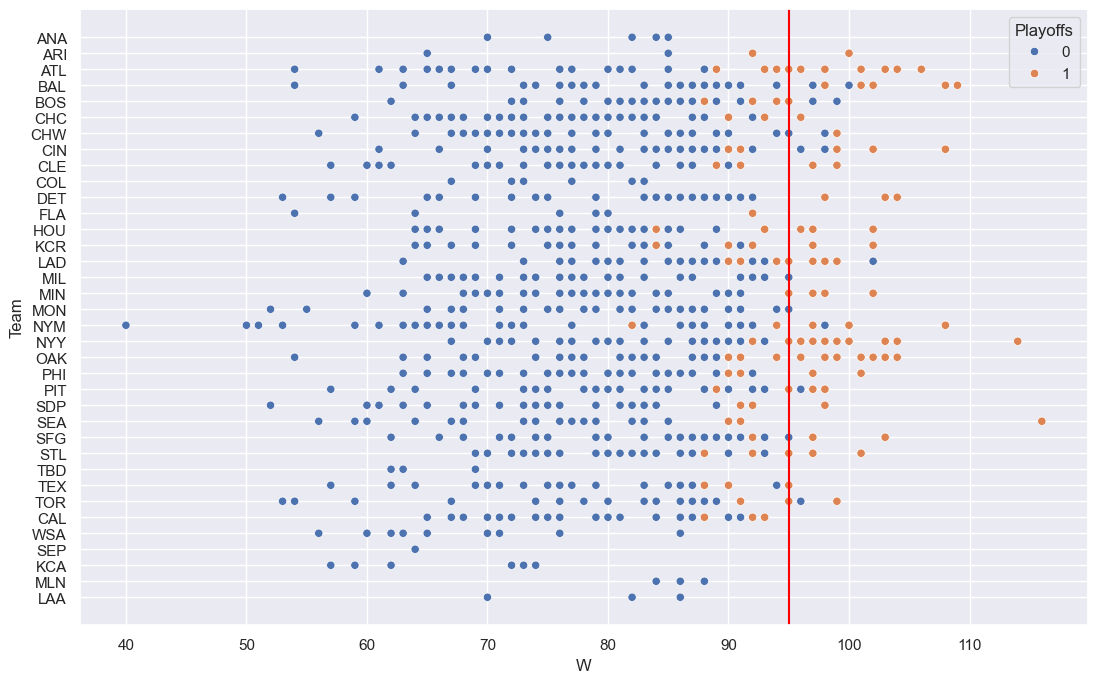

In [28]:
sns.set()
plt.figure(figsize=(13, 8))
ax = sns.scatterplot(df, x='W', y='Team', hue='Playoffs')
ax.axvline(x=95, color='red')


# HOW TO WIN 95 GAMES...

In [33]:
what_we_are_trying_to_predict = 'W'
data_we_have_related_to_games = ['runs_diff']
model = do_moneyball(df, data_we_have_related_to_games, what_we_are_trying_to_predict)

###############################################################################
Predicting: W
Using: ['runs_diff']
###############################################################################
///////////////////////////////////////////////////////////////////////////////
EVAL ON TESTING DATA
R-Squared Score: 0.8808
RMSE: 3.9347
Dependent Variable W average:  80.881
///////////////////////////////////////////////////////////////////////////////
-------------------------------------------------------------------------------
EVAL ON TESTING DATA
R-Squared Score: 0.8878
RMSE: 3.9057
Dependent Variable W average:  80.8814
On average our prediction is %0.0483 the dependent variable
None
-------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:              

# We use this model to find our target runs difference we need to get 95 wins. 

In [ ]:
# Using these coefficients...  find 95


# 95 >= 80 + 0.1*x 

# x is what we are hunting for. 

########################################
# 95-80 = 0.1x

# 15 = 0.1x

# 15/0.1 = 150

In [ ]:
coef_y_int = model.params['const']
coef_runs_diff = model.params['runs_diff']

## y = m*x + b
## x = y-b / m

### THIS IS SAME AS ABOVE
y_intercept = 80.88
m_coefficient = 0.1058
# x = ???

y = 95
x_target = (y - y_intercept) / m_coefficient
x_target


133.45935727788284

In [71]:
independent_variables = ['OBP', 'SLG']
dependent_variable = 'RS'

X = df[independent_variables]
y = df[dependent_variable]

X = sm.add_constant(X)

model_runs_scored = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
print(model_runs_scored.summary())

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5934.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:57:59   Log-Likelihood:                -4174.2
No. Observations:                 902   AIC:                             8354.
Df Residuals:                     899   BIC:                             8369.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -804.6271     18.921    -42.526      0.0

In [70]:
dfo = df.dropna(subset=['OOBP', 'OSLG'])
independent_variables = ['OOBP', 'OSLG']
dependent_variable = 'RA'

X = dfo[independent_variables]
y = dfo[dependent_variable]

X = sm.add_constant(X)

model_runs_allowed = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
print(model_runs_allowed.summary())

                            OLS Regression Results                            
Dep. Variable:                     RA   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     425.8
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           1.16e-45
Time:                        17:57:41   Log-Likelihood:                -418.27
No. Observations:                  90   AIC:                             842.5
Df Residuals:                      87   BIC:                             850.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -837.3779     60.255    -13.897      0.0

In [81]:
### FUTURE 2001 A's would have

const = 1
OBP = 0.339
SLG = 0.430

predicted_runs_scored = model_runs_scored.predict([const, OBP, SLG])
print(predicted_runs_scored)


## FUTURE OPPONENTS WOULD HAVE
OOBP = 0.307
OSLG = 0.373
predicted_runs_allowed = model_runs_allowed.predict([const, OOBP, OSLG])
print(predicted_runs_allowed)

predicted_runs_diff = predicted_runs_scored - predicted_runs_allowed
predicted_runs_diff

[804.98699884]
[621.92581602]


array([183.06118281])

In [82]:
independent_variables = ['runs_diff',]
dependent_variable = 'W'

X = df[independent_variables]
y = df[dependent_variable]

X = sm.add_constant(X)

model_wins = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
# print(model_wins.summary())
model_wins.predict([1, predicted_runs_diff[0]])


array([100.24295467])

Optimization terminated successfully.
         Current function value: 0.201536
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               Playoffs   No. Observations:                  902
Model:                          Logit   Df Residuals:                      900
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                  0.5590
Time:                        18:04:32   Log-Likelihood:                -181.79
converged:                       True   LL-Null:                       -412.25
Covariance Type:            nonrobust   LLR p-value:                3.005e-102
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.1718      2.638    -12.196      0.000     -37.342     -27.002
W              0.3461      0.

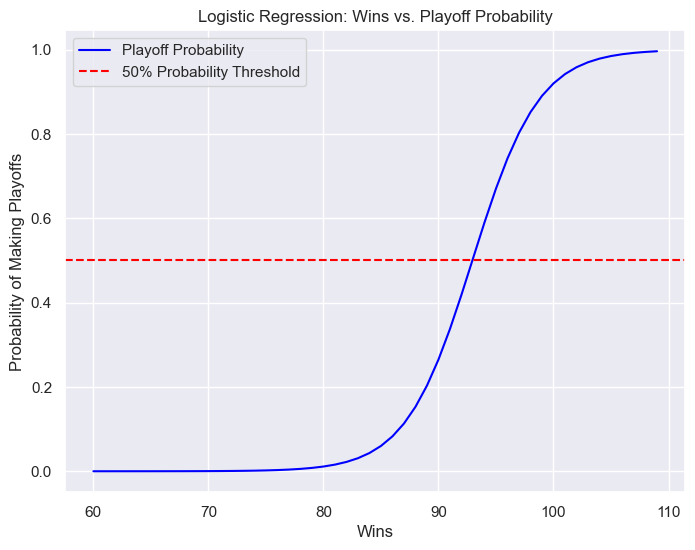

,const,W,Playoff_Probability
30,1.0,90,0.264932
31,1.0,91,0.337521
32,1.0,92,0.418670
33,1.0,93,0.504473
34,1.0,94,0.590012
35,1.0,95,0.670433
36,1.0,96,0.741977
37,1.0,97,0.802564
38,1.0,98,0.851766
39,1.0,99,0.890382


In [83]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = df.copy()

# Define the independent (Wins) and dependent (Playoff status) variables
X = sm.add_constant(data[['W']])  # Add constant for intercept
y = data['Playoffs']  # Playoff status

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Display the summary of the logistic regression model
print(logit_model.summary())

# Predict the probability of making the playoffs for a range of wins
wins_range = pd.DataFrame({'W': range(60, 110)})  # Wins from 60 to 109
wins_range = sm.add_constant(wins_range)  # Add constant

# Generate playoff probabilities using the logistic regression model
wins_range['Playoff_Probability'] = logit_model.predict(wins_range)

# Plot the playoff probability curve
plt.figure(figsize=(8, 6))
plt.plot(wins_range['W'], wins_range['Playoff_Probability'], color='blue', label='Playoff Probability')
plt.axhline(0.5, color='red', linestyle='--', label='50% Probability Threshold')
plt.xlabel('Wins')
plt.ylabel('Probability of Making Playoffs')
plt.title('Logistic Regression: Wins vs. Playoff Probability')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

wins_range.iloc[30:40]

# How to Sanity Check your model (not covering in class)
--- 
NICE TO COVER IF WE HAVE TIME.  
# Checking Assumptons
1. Linearity
2. Homoscedasticity
3. Normality of Errors
4. Multicollinearity
5. Outliers

In [ ]:
independent_variables = ['OBP', 'SLG']
dependent_variable = 'RS'

X = df[independent_variables]
y = df[dependent_variable]

X = sm.add_constant(X)

model_runs_scored = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
print(model_runs_scored.summary())

In [ ]:
# Checking for Multicollinearity 

### Member this summary report and why i asked if it looked strange?

independent_variables = ['OBP', 'SLG', 'BA']
dependent_variable = 'RS'

X = df[independent_variables]

y = df[dependent_variable]

X = sm.add_constant(X)

model_runs_scored = sm.OLS(y, X).fit()
print(model_runs_scored.summary())
# This looks strange because batting average shouldn't be NEGATIVELY affecting Runs scored... 
## Why is this happening.  
# Checking mulitcollinearity
plt.figure(figsize = (3,3))

ax = sns.heatmap( df[independent_variables].corr(numeric_only=True), 
            annot=True, 
            cmap='coolwarm',
            vmin=-1, vmax=1);
plt.show()
# https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df = pd.DataFrame(columns=X.columns, data=[vif])
print('#'*79)
print('Variance Inflaction Factors')
print(vif_df)
print('#'*79)
